#Arabic Character Recognition

##Overview
This notebook builds an OCR for handwritten Arabic letters, research in OCR or optical character recognition started a long time ago in order to allow the computer to understand the words in any visual image, but the peak in OCR performances did happen in the deep learning era as it introduced advanced methods and techniques in order to achieve the OCR's outstanding outcomes and uses. 
The dataset used will be from Benha University, and the CNN will be build using Keras from TensorFlow.

##Dataset
The data-set is composed of 16,800 characters written by 60 participants, the age range is between 19 to 40 years, and 90% of participants are right-hand. Each participant wrote each character (from ’alef’ to ’yeh’) ten times on two forms as shown in Fig. 7(a) & 7(b). The forms were scanned at the resolution of 300 dpi. Each block is segmented automatically using Matlab 2016a to determining the coordinates for each block. The database is partitioned into two sets: a training set (13,440 characters to 480 images per class) and a test set (3,360 characters to 120 images per class). Writers of training set and test set are exclusive. Ordering of including writers to test set are randomized to make sure that writers of test set are not from a single institution (to ensure variability of the test set).

https://www.kaggle.com/mloey1/ahcd1

## Data Exploring & Preprocessing

1- Let's import our libraries that we will use in this project.

In [1]:
import tensorflow as tf                                                         # The main framework we will build our model with.
import numpy as np                                                              # Used for mathimatical operations.
import pandas as pd                                                             # Will be used to load our data frame.
import cv2                                                                      # Used for image processing.
from matplotlib import pyplot as plt                                            # Used for plottin our data.
from tensorflow.keras.utils import to_categorical                               # Utility in Tensorflow to convert our true category values.

2- Now we wil mount google drive for loading our data.

In [2]:
from google.colab import drive                                                  
drive.mount('/content/gdrive')

Mounted at /content/gdrive


3- We will use Pandas library to read our data and load it into our data frame, our data is stored in CSV format so we will use the appropriate function to load it.

In [3]:
path = '/content/gdrive/MyDrive/Datasets/Kaggle Arabic Characters'              # Here we specify the path to our data location on my drive
train_data_x = pd.read_csv(path + '/csvTrainImages 13440x1024.csv', header=None)# Then we load the training images.
train_data_y = pd.read_csv(path + '/csvTrainLabel 13440x1.csv', header=None)    # Training labels.
test_data_x = pd.read_csv(path + '/csvTestImages 3360x1024.csv', header=None)   # Testing images.
test_data_y = pd.read_csv(path + '/csvTestLabel 3360x1.csv', header=None)       # Testing labels.

4- Now let's examine our data properties.

We will find that we have 13440 training image with their labels in the training set and 3360 in the testing set, along with a total of 28 classes which idecates the number of Arabic letters.

The number of pixels in each image is 1024, so we can conclude the pixels per image by getting the square root of the number of pixels which will give us 32, so the dimensions of our image is 32x32x1 as it is a grey scale image, we will use this piece of information for preprocessing our images.

In [92]:
print('We have  %d training images each contains %d pixels.' %(train_data_x.shape[0], train_data_x.shape[1]))
print('We have  %d training labels each contains %d classes.' %(train_data_y.shape[0], len(train_data_y.value_counts())))
print('We have  %d testing images each contains %d pixels.' %(test_data_x.shape[0], test_data_x.shape[1]))
print('We have  %d testing labels each contains %d classes.' %(test_data_y.shape[0], len(test_data_y.value_counts())))

We have  13440 training images each contains 1024 pixels.
We have  13440 training labels each contains 28 classes.
We have  3360 testing images each contains 1024 pixels.
We have  3360 testing labels each contains 28 classes.


We notice also that there are 480 image per class, and there is also a very important note that we should put into consideration, the classes start from 1 to 28, but for our classifer we would like our classes to be from 0 to 27, we will use this piece of information in preprocessing the labels. 

In [93]:
train_data_y.value_counts()

28    480
27    480
2     480
3     480
4     480
5     480
6     480
7     480
8     480
9     480
10    480
11    480
12    480
13    480
14    480
15    480
16    480
17    480
18    480
19    480
20    480
21    480
22    480
23    480
24    480
25    480
26    480
1     480
dtype: int64

Let's see what our images looks like.

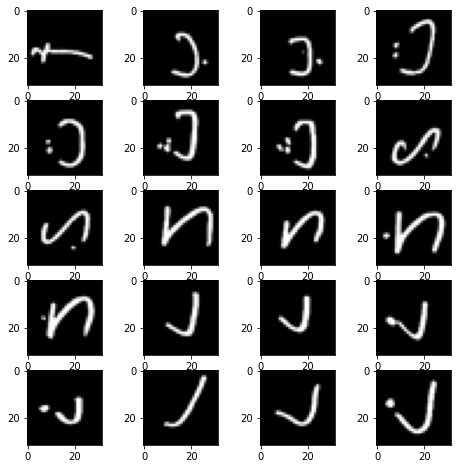

In [96]:
fig = plt.figure(figsize=(8, 8))                                                # Setting the figure size.
columns = 4                                                                     # Selecting the number of columns.
rows = 5                                                                        # Selectin the number of rows.
for i in range(1, columns*rows +1):                                             # Looping through rows & columns.
  img = test_data_x.iloc[i].to_numpy().reshape((32,32))                         # Reshaping the image into its size 32x32
  fig.add_subplot(rows, columns, i)                                             # Adding the image to the plot
  plt.imshow(img, cmap='gray')                                                  # Showing the image using plt
plt.show()                                                                      # Finally shpwing the whole plot containing all the subplots

5- Now we define a function for us to preprocess the data,

We will start with reshaping the image to be with the size of 32x32, so that the training array will be of size of #imagesx32x32, then we will pass through each image to flip and rotate them as they are rotated, then we will reshape the entire array with the #imagex32x32x1, and the 1 stands for our grey scale images, lastly we will normalize our images by dividing by 255 for pixels normalization.

In [4]:
def preprocess_data(train_data_x):
  train_data_x = train_data_x.to_numpy().reshape((train_data_x.shape[0], 32, 32)).astype('uint8')
  for i in range(len(train_data_x)):
    train_data_x[i] = cv2.rotate(train_data_x[i], cv2.ROTATE_90_CLOCKWISE)      # Rotating the images.
    train_data_x[i] = np.flip(train_data_x[i], 1)                               # Flipping the images
  train_data_x = train_data_x.reshape([-1, 32, 32, 1]).astype('uint8')          # Reshaping into the required size.
  train_data_x = train_data_x.astype('float32')/255                             # Here we normalize our images.
  return np.asarray(train_data_x)

In [5]:
train_x = preprocess_data(train_data_x)                                         # Returns an array of dimensions (13440,32,32,1).
test_x = preprocess_data(test_data_x)                                           # Returns an array of dimensions (3360,32,32,1).

6- Now we preprocess our labels by converting them to the categorcal form.

Note: we subtracted one from the values of the labels we so get our classes values in the form of 0-27 as we mentioned earlier.

In [6]:
train_y = to_categorical(train_data_y.values.astype('int32') - 1                # Returns an array of dimentions (13340, 28).
                         , num_classes=28)
test_y = to_categorical(test_data_y.values.astype('int32') - 1                  # Returns an array of dimentions (3360, 28).
                        , num_classes=28)

7- We will now shuffle our training and test sets as we will get better results than using the data's classes in sequential form.

In [ ]:
from sklearn.utils import shuffle                                               # Importing shuffle function from sklearn library.
train_x, train_y = shuffle(train_x, train_y)                                    # Now we shuffle x & y in the training set.
test_x, test_y, shuffle(test_x, test_y)                                         # Then x & y in our testing set.

## Building Model

8- We will now create our model's architecture, 

We will use keras for the creation of our model, we will start by creating a function for use to create our model, we will set the activation, optimizer and our initializing method as variables for us to easly modifiy it in the hyper-parameter tuning phase.

We will start by creating our first convolutional layer and setting up the input shape, we will create additional pooling layer along with a batch normalization layer, then we will add three convolutional layers with the same structure but the the double size of filters each layer.

Then we will flatten our layer preparing it for the fully connected layers, we will use a small neurons numbered layer with a drop out layer, batch normalization and we will add an L2 regularizer so we will control the overfitting.

In [45]:
def create_model(activation='relu', optimizer='adam', kernel_initializer='he_normal'):
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), padding='same', input_shape=(32, 32, 1), activation= activation, kernel_initializer=kernel_initializer),
      tf.keras.layers.MaxPool2D(2,2),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(64, (3,3), padding='same', activation= activation, kernel_initializer=kernel_initializer),
      tf.keras.layers.MaxPool2D(2,2),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(128, (3,3), padding='same', activation= activation, kernel_initializer=kernel_initializer),
      tf.keras.layers.MaxPool2D(2,2),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.BatchNormalization(),

      tf.keras.layers.Flatten(),
      
      tf.keras.layers.Dense(32, activation= activation, kernel_initializer=kernel_initializer, kernel_regularizer='l2'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(28, activation= 'softmax', kernel_initializer=kernel_initializer)
  ])

  model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model

In [46]:
model = create_model()                                                          # Now we created an instance of a model with our custom architefture.
model.summary()                                                                 # Then we display our model's summary.

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_37 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_38 (Batc (None, 8, 8, 64)        

9- Let's start selecting the best hyperparamters for our model, we will do this by performing grid parameter tuning, which indicates performing all the possible combinations for our hyperparameters, then selecting the combination by selecting the best model.

In [97]:
seed = 7                                                                        # Select a fixed seed
np.random.seed(seed)                                                            # Specifing the seed for our random generator

optimizer = ['RMSprop', 'Adam', 'Adagrad', 'Nadam']                             # Available optimizers
kernel_initializer = ['normal', 'uniform']                                      # Available initializing methods
activation = ['relu', 'linear', 'tanh']                                         # Available activation functions

param_grid = dict(optimizer=optimizer,                                          # Creating the grid
                  kernel_initializer=kernel_initializer,
                  activation=activation)

parameters_number = 1
for x in param_grid:
  parameters_number = parameters_number * len(param_grid[x]) 
print("Number of different parameter combinations = {}".format(parameters_number))

Number of different parameter combinations = 24


In [100]:
epochs = 5                                                                      # Specifing the number of epochs for each combination
batch_size = 64                                                                 # Setting the batch size

# Here we will create our different models and run them for 5 epochs each.
for a,b,c in [(x,y,z) for x in optimizer for z in activation for y in kernel_initializer]:
    params = {'optimizer' : a , 'kernel_initializer' : b , 'activation' : c}
    print(params)
    curr_model = create_model(optimizer=a, kernel_initializer=b, activation=c)
    curr_model.fit(train_x, train_y, 
                    validation_split=0.3,
                    epochs=epochs, batch_size=batch_size, verbose=1)
    print("=============================================================================")

{'optimizer': 'RMSprop', 'kernel_initializer': 'normal', 'activation': 'relu'}
Epoch 1/5
147/147 [==============================] - 15s 91ms/step - loss: 7.0349 - accuracy: 0.3186 - val_loss: 6.3231 - val_accuracy: 0.0449
Epoch 2/5
147/147 [==============================] - 13s 90ms/step - loss: 2.5613 - accuracy: 0.6649 - val_loss: 4.9608 - val_accuracy: 0.0370
Epoch 3/5
147/147 [==============================] - 13s 90ms/step - loss: 1.4419 - accuracy: 0.7851 - val_loss: 4.4508 - val_accuracy: 0.0856
Epoch 4/5
147/147 [==============================] - 13s 89ms/step - loss: 1.1330 - accuracy: 0.8256 - val_loss: 3.3168 - val_accuracy: 0.1982
Epoch 5/5
147/147 [==============================] - 13s 89ms/step - loss: 0.9872 - accuracy: 0.8490 - val_loss: 1.1609 - val_accuracy: 0.7946
{'optimizer': 'RMSprop', 'kernel_initializer': 'uniform', 'activation': 'relu'}
Epoch 1/5
147/147 [==============================] - 15s 91ms/step - loss: 3.5339 - accuracy: 0.4205 - val_loss: 4.6654 - val_

10- After looping through all the combinations it was found that the best combination is:

 [RMS Prop, Normal Initialization, Relu Activation]

 Then lets use them to build our final model.

In [52]:
model = create_model(optimizer='RMSprop',                                       # We create our model with the specified hyper parameters
                     kernel_initializer='normal',
                     activation='relu')

In [54]:
from keras.callbacks import ModelCheckpoint                                     # We will import a call back to save the best epoch's weights

checkpointer = ModelCheckpoint(filepath='weights.hdf5', verbose=1, save_best_only=True)
history = model.fit(train_x,                                                    
                    train_y, 
                    validation_split= 0.3,                                      # The model will split the data into 30% of validation.
                    epochs=30,                                                  # We will run the model for 30 epochs
                    batch_size=64,                                              # We will have a batch size of 64
                    callbacks=[checkpointer])                                   # Finally we will use the imported callback

Epoch 1/30
147/147 [==============================] - 23s 156ms/step - loss: 2.5368 - accuracy: 0.5354 - val_loss: 4.4422 - val_accuracy: 0.0357

Epoch 00001: val_loss improved from inf to 4.44219, saving model to weights.hdf5
Epoch 2/30
147/147 [==============================] - 23s 155ms/step - loss: 1.1869 - accuracy: 0.8050 - val_loss: 4.5659 - val_accuracy: 0.0357

Epoch 00002: val_loss did not improve from 4.44219
Epoch 3/30
147/147 [==============================] - 23s 155ms/step - loss: 0.6753 - accuracy: 0.8866 - val_loss: 2.8348 - val_accuracy: 0.1022

Epoch 00003: val_loss improved from 4.44219 to 2.83476, saving model to weights.hdf5
Epoch 4/30
147/147 [==============================] - 23s 154ms/step - loss: 0.4707 - accuracy: 0.9139 - val_loss: 0.7733 - val_accuracy: 0.8591

Epoch 00004: val_loss improved from 2.83476 to 0.77327, saving model to weights.hdf5
Epoch 5/30
147/147 [==============================] - 23s 154ms/step - loss: 0.3747 - accuracy: 0.9307 - val_loss:

11- Now lets load the best epoch's weights and then evaluate our model using the test set.

In [55]:
model.load_weights('weights.hdf5')                                              # Loading the best weights        
model.evaluate(test_x, test_y)                                                  # Evaluating our model

105/105 [==============================] - 2s 21ms/step - loss: 0.2200 - accuracy: 0.9634


[0.21995072066783905, 0.9633928537368774]

12- Lets plot our training journy to check the performance and verify that the model is not overfitting.

Text(0.5, 1.0, 'Training and validation loss')

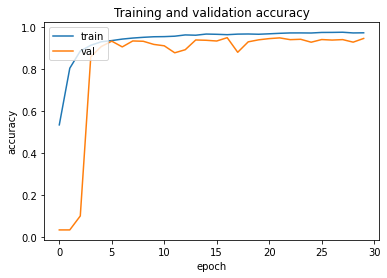

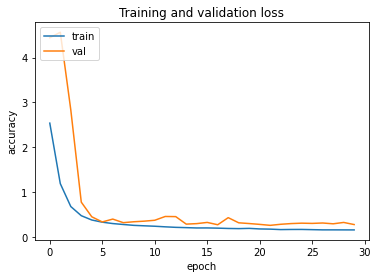

In [56]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation loss')
plt.legend(['train', 'val'], loc='upper left')
plt.ylabel('accuracy')
plt.xlabel('epoch')


plt.title('Training and validation loss')


12- Lets save our model for later use

In [59]:
model.save('/content/my_model/my_model.h5')

##Testing Model

Now lets load our model and test it on our custom images.

In [111]:
model = tf.keras.models.load_model('my_model/my_model.h5')                      # Now we load the model

105/105 [==============================] - 2s 12ms/step - loss: 0.4697 - accuracy: 0.9563


[0.4696522355079651, 0.956250011920929]

In the following function we mapped the categorical output with the Arabic letters to help us better identifing the classes.

In [60]:
def convert_categorical_label_to_real_label(categorical_label):
  real_labels = []
  real_labels.extend(['أ', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ى'])
  return real_labels[categorical_label]

Finally lets test them on custom images.

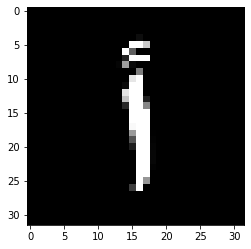

أ


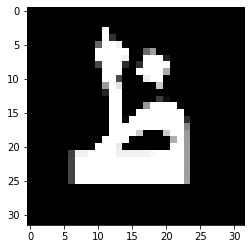

ظ


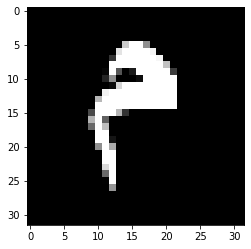

م


In [101]:
for i in range(1, 4):
  test = cv2.imread('z' + str(i) + '.png')
  test = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)
  test = cv2.resize(test, (32, 32))
  plt.imshow(test, cmap='gray')
  plt.show()
  test = np.reshape(test, (-1, 32, 32, 1))
  test = test.astype('float32')/255
  print(convert_categorical_label_to_real_label(np.argmax(model.predict(test))))

## Acknowledgments

• Author: **Hossam Zaabl**

https://github.com/zaabl

• A. El-Sawy, M. Loey, and H. EL-Bakry, “Arabic handwritten characters recognition using convolutional neural network,” WSEAS Transactions on Computer Research, vol. 5, pp. 11–19, 2017.

https://doi.org/10.1007/978-3-319-48308-5_54

https://link.springer.com/chapter/10.1007/978-3-319-48308-5_54

• A. El-Sawy, H. EL-Bakry, and M. Loey, “CNN for handwritten arabic digits recognition based on lenet-5,” in Proceedings of the International Conference on Advanced Intelligent Systems and Informatics 2016, vol. 533, pp. 566–575, Springer International Publishing, 2016.

https://www.wseas.org/multimedia/journals/computerresearch/2017/a045818-075.php

• Loey, Mohamed, Ahmed El-Sawy, and Hazem El-Bakry. "Deep learning autoencoder approach for handwritten arabic digits recognition." arXiv preprint arXiv:1706.06720 (2017).
https://arxiv.org/abs/1706.06720

• Amr Hendy, Arabic Handwritten Image Recognition

https://github.com/AmrHendy/Arabic-Handwritten-Images-Recognition